In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import norm, lognorm, anderson, kstest
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None

In [5]:
# Data setup
date = 'both' # 'both' or '0218' or '0302'
drop_ad = True      # remove anderson-darling stat from predictors
drop_vv_glcm = True # remove all VV GLCM vars from predictors
s1_unit = 'dB' # 'raw_power' or 'dB'
moran_stat = 'med' # 'max' or 'med'

# RF parameters
rf_target_cols = ['moran'] # must be in a list (even for one column)
n_runs = 500
rf_type = 'single_target' # 'single_target' or 'multi_target' (currently only up to 2 targets supported)
output_figures = True
hex_figure_fname = f'output/figures/hex/moran_med_bothdates_cleandata_dB.png'
output_predictions = True
prediction_fname = f'output/rf_predictions/moran_med_bothdates_cleandata_dB.csv'
output_metrics = True # For multi_target runs
metrics_fname = 'output/rf_metrics/moran_med_500_dB_cleandata_bothdates.csv'

ntrees = 2000        # 2000 recommended in https://hess.copernicus.org/articles/25/2997/2021/
mtry = 2/3           # From paper above; passed to 'max_features' kwarg in RF regressor
max_depth = 7        # Max depth of each tree
train_frac = 0.7     # Only relevant if train_type == 'timeseries' or 'random'
random_state = 5033  # For reproducibility

In [6]:
# Data setup
# Start with S1 data
s1_data = pd.read_csv('input_data/s1_data.csv')
s1_data['date'] = s1_data['date'].astype(str).str.zfill(4)
s1_data.index = pd.MultiIndex.from_arrays([s1_data['date'], s1_data['S1_pixel_ID']])
s1_data.drop(columns=['date','S1_pixel_ID'], inplace=True)
s1_data.sort_index(inplace=True)

target_cols = [col for col in s1_data.columns if 'roughness' in col]
predict_cols = [col for col in s1_data.columns if col not in target_cols]
targets = s1_data[target_cols]
predictors = s1_data[predict_cols]

# Create derived metrics - predictors
if s1_unit == 'dB':
    predictors['VV'] = 10*np.log10(predictors['VV'])
    predictors['VH'] = 10*np.log10(predictors['VH'])
if drop_vv_glcm:
    predictors.drop(columns=[col for col in predictors.columns if 'VV_GLCM' in col], inplace=True)
predictors['vv_vh_ratio'] = predictors['VV']/predictors['VH']
predictors['vh_vv_ratio'] = predictors['VH']/predictors['VV']
predictors['vv2'] = predictors['VV']**2
predictors['vh2'] = predictors['VH']**2
predictors['vv_inv'] = 1/predictors['VV']
predictors['vh_inv'] = 1/predictors['VH']
predictors['multiply'] = predictors['VV'] * predictors['VH']

# Target derived metrics
targets['iqr'] = targets['roughness_p75'] - targets['roughness_p25']
targets['p95-p5'] = targets['roughness_p95'] - targets['roughness_p5']

# Add lognorm fit parameters into targets
stats_data = pd.read_csv('output/stats/scale_shape_both_dates.csv')
stats_data['date'] = stats_data['date'].astype(str).str.zfill(4)
stats_data.index = pd.MultiIndex.from_arrays([stats_data['date'], stats_data['S1_pixel_ID']])
stats_data.drop(columns=['date','S1_pixel_ID'], inplace=True)
if drop_ad:
    stats_data.drop(columns=['ad'], inplace=True)
targets = targets.join(stats_data)

# Add moran data into targets
moran = pd.read_csv(f'input_data/moran_{moran_stat}.csv')
moran['date'] = moran['date'].astype(str).str.zfill(4)
moran.index = pd.MultiIndex.from_arrays([moran['date'], moran['S1_pixel_ID']])
moran.drop(columns=['date','S1_pixel_ID'], inplace=True)
moran.columns = ['moran','moran_z','moran_p']
targets = targets.join(moran)


targets.head(10)

roughness_p5  roughness_p25  roughness_p75  roughness_p95  \
date S1_pixel_ID                                                              
0218 1                0.001254       0.002675       0.008086       0.018360   
     2                0.000937       0.001725       0.004034       0.007187   
     3                0.000801       0.001428       0.003210       0.005620   
     4                0.000811       0.001450       0.003412       0.007025   
     5                0.000788       0.001558       0.004713       0.009320   
     6                0.000610       0.001024       0.002092       0.003465   
     7                0.000913       0.001643       0.003662       0.006077   
     8                0.000886       0.001591       0.003583       0.006042   
     9                0.000693       0.001643       0.006792       0.016802   
     10               0.000972       0.002055       0.006152       0.012170   

                       iqr    p95-p5     scale     shape        ks  moran  \
date S1_pixel_ID                                                            
0218 1            0.005411  0.017106  0.004689  0.816457  0.006510    NaN   
     2            0.002309  0.006250  0.002629  0.619090  0.010317    NaN   
     3            0.001782  0.004819  0.002132  0.591836  0.006076    NaN   
     4            0.001961  0.006214  0.002266  0.660623  0.021772    NaN   
     5            0.003155  0.008532  0.002731  0.776050  0.019981    NaN   
     6            0.001068  0.002856  0.001467  0.527784  0.007962    NaN   
     7            0.002019  0.005164  0.002427  0.578544  0.015578    NaN   
     8            0.001992  0.005156  0.002377  0.589737  0.010702    NaN   
     9            0.005150  0.016108  0.003451  0.982001  0.030490    NaN   
     10           0.004097  0.011199  0.003579  0.777333  0.019393    NaN   

                  moran_z  moran_p  
date S1_pixel_ID                    
0218 1                NaN      NaN  
     2                NaN      NaN  
     3                NaN      NaN  
     4                NaN      NaN  
     5                NaN      NaN  
     6                NaN      NaN  
     7                NaN      NaN  
     8                NaN      NaN  
     9                NaN      NaN  
     10               NaN      NaN

In [16]:
RandomForestRegressor(**{'n_estimatorss':200})

TypeError: __init__() got an unexpected keyword argument 'n_estimatorss'

Expand cell below for RF analysis

2022-05-23 14:35:32 -- Starting target moran
2022-05-23 15:11:24 -- 100/500 complete.
2022-05-23 15:42:51 -- 200/500 complete.
2022-05-23 16:14:06 -- 300/500 complete.
2022-05-23 16:46:23 -- 400/500 complete.
2022-05-23 17:19:38 -- 500/500 complete.


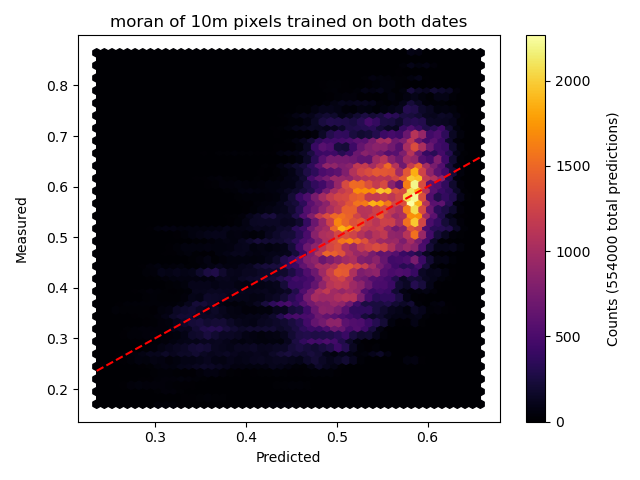

In [16]:
# RF analysis - single target column
if rf_type == 'single_target':
    
    # Some initial setup
    for target_col in rf_target_cols:
        print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
              f'-- Starting target {target_col}')
        X = predictors
        y = targets[target_col]
        valid_list, predict_list = [], []
        if date == 'both':
            nsamples_0218 = int(targets.loc['0218'].shape[0]*train_frac)
            nsamples_0302 = int(targets.loc['0302'].shape[0]*train_frac)
        
        rf = RandomForestRegressor(n_estimators=ntrees,
                           max_features=mtry,
                           max_depth=max_depth, 
                           random_state=random_state)
        
        # Loop of RF runs
        for i in range(n_runs):
            # Train/test split
            if date == 'both':
                train_ind_0218 = pd.MultiIndex.from_product([['0218'], targets.loc['0218'].sample(nsamples_0218).index])
                train_ind_0302 = pd.MultiIndex.from_product([['0302'], targets.loc['0302'].sample(nsamples_0302).index])
                train_ind = train_ind_0218.union(train_ind_0302)
                test_ind = targets[~targets.index.isin(train_ind)].index
                X_train, X_test = X.loc[train_ind], X.loc[test_ind]
                y_train, y_test = y.loc[train_ind], y.loc[test_ind]
            else:
                X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_frac)
            # Fit and predict
            rf.fit(X_train, y_train)
            predictions = rf.predict(X_test)
            # Save values to list
            valid_list.extend(y_test.values.tolist())
            predict_list.extend(predictions)
            if i != 0 and not (i+1)%100:
                print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                      f'-- {i+1}/{n_runs} complete.')
        
        if output_predictions:
            output = pd.DataFrame(np.array([valid_list, predict_list]).T, columns=['valid','predict'])
            output.to_csv(prediction_fname)
        
        
        plt.close('all')
        fig, ax = plt.subplots()
        hex1 = ax.hexbin(predict_list, valid_list, gridsize=50, cmap='inferno')
        ax.plot((min(predict_list), max(predict_list)), (min(predict_list), max(predict_list)), 'r--')
        cb1 = fig.colorbar(hex1, ax=ax)
        cb1.set_label(f'Counts ({len(predict_list)} total predictions)', labelpad=12)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Measured', labelpad=12)
        ax.set_title(f'{target_col} of 10m pixels trained on both dates')
        plt.tight_layout()
        if output_figures:
            fig.savefig(hex_figure_fname, dpi=300)

# Multiple target columns (currently only 2 supported)
elif rf_type == 'multi_target':
    # Some initial setup
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
      f'-- Starting multi-target runs with {rf_target_cols}')
    X = predictors
    y = targets[rf_target_cols]
    rmse_list, mae_list, r2_list = [], [], []
    valid_x_list, valid_y_list, predict_x_list, predict_y_list = [], [], [], []
    if date == 'both':
        nsamples_0218 = int(targets.loc['0218'].shape[0]*train_frac)
        nsamples_0302 = int(targets.loc['0302'].shape[0]*train_frac)
    
    rf = RandomForestRegressor(n_estimators=ntrees,
                       max_features=mtry,
                       max_depth=max_depth, 
                       random_state=random_state)
    
    # Loop through RF runs
    for i in range(n_runs):
        # Train/test split
        if date == 'both':
            train_ind_0218 = pd.MultiIndex.from_product([['0218'], targets.loc['0218'].sample(nsamples_0218).index])
            train_ind_0302 = pd.MultiIndex.from_product([['0302'], targets.loc['0302'].sample(nsamples_0302).index])
            train_ind = train_ind_0218.union(train_ind_0302)
            test_ind = targets[~targets.index.isin(train_ind)].index
            X_train, X_test = X.loc[train_ind], X.loc[test_ind]
            y_train, y_test = y.loc[train_ind], y.loc[test_ind]
        else:
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_frac)
        # Fit and predict
        rf.fit(X_train, y_train)
        predictions = rf.predict(X_test)
        # Save all values for hexbin plots
        valid_x_list.extend(y_test.iloc[:,0].values.tolist())
        valid_y_list.extend(y_test.iloc[:,1].values.tolist())
        predict_x_list.extend(predictions[:,0])
        predict_y_list.extend(predictions[:,1])
        # Metrics
        rmse = metrics.mean_squared_error(y_test, predictions, squared=False) # squared=True -> MSE
        mae = metrics.mean_absolute_error(y_test, predictions)
        r2 = metrics.r2_score(y_test, predictions)
        rmse_list.append(rmse)
        mae_list.append(mae)
        r2_list.append(r2)

        if i != 0 and not (i+1)%(n_runs//5):
            print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                  f'-- {i+1}/{n_runs} runs complete.')

    if output_metrics:
        metrics_df = pd.DataFrame(np.array([rmse_list, mae_list, r2_list]).T, columns=['RMSE','MAE','R2'])
        metrics_df.to_csv(metrics_fname)

    plt.close('all')
    fig, ax = plt.subplots()
    sns.violinplot(data=metrics_df, ax=ax)
    plt.show()

    #plt.close('all')
    fig, ax = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
    extent = [0, 0.003, 0.4, 0.7]
    #extent = [min(valid_x_list), max(valid_x_list), min(valid_y_list), max(valid_y_list)]
    hex0 = ax[0].hexbin(valid_x_list, valid_y_list, gridsize=50, extent=extent, cmap='inferno')
    cb0 = fig.colorbar(hex0, ax=ax[0])
    ax[0].set_title(f'Validation data ({n_runs} RF runs)')
    ax[0].set_xlabel('lognorm scale ($\mu$)')
    ax[0].set_ylabel('lognorm scale ($\sigma$)')
    hex1 = ax[1].hexbin(predict_x_list, predict_y_list, gridsize=50, extent=extent, cmap='inferno')
    cb1 = fig.colorbar(hex1, ax=ax[1])
    cb1.set_label('Counts')
    ax[1].set_title(f'RF Predictions ({n_runs} RF runs)')
    ax[1].set_xlabel('lognorm shape ($\mu$)')
    plt.tight_layout()
    if output_figures:
        fig.savefig(hex_figure_fname, dpi=300)

In [ ]:
plt.close('all')
fig, ax = plt.subplots()
sns.violinplot(data=metrics_df, ax=ax)
plt.show()

#plt.close('all')
fig, ax = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
extent = [0, 0.003, 0.4, 0.7]
#extent = [min(valid_x_list), max(valid_x_list), min(valid_y_list), max(valid_y_list)]
hex0 = ax[0].hexbin(valid_x_list, valid_y_list, gridsize=50, extent=extent, cmap='inferno')
cb0 = fig.colorbar(hex0, ax=ax[0])
ax[0].set_title(f'Validation data ({n_runs} RF runs)')
ax[0].set_xlabel('lognorm scale ($\mu$)')
ax[0].set_ylabel('lognorm scale ($\sigma$)')
hex1 = ax[1].hexbin(predict_x_list, predict_y_list, gridsize=50, extent=extent, cmap='inferno')
cb1 = fig.colorbar(hex1, ax=ax[1])
cb1.set_label('Counts')
ax[1].set_title(f'RF Predictions ({n_runs} RF runs)')
ax[1].set_xlabel('lognorm shape ($\mu$)')
plt.tight_layout()
if output_figures:
    fig.savefig(hex_figure_fname, dpi=300)

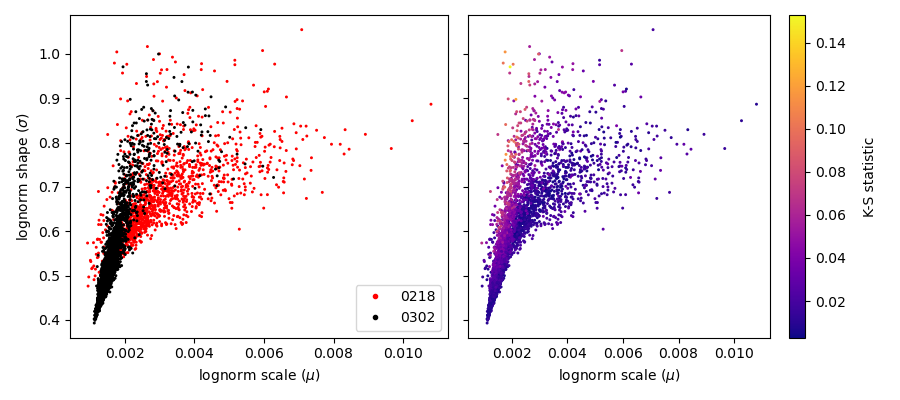

In [23]:
date_colors  = ['r' if i[0] == '0218' else 'k' for i in targets.index]
fig, ax = plt.subplots(1, 2, figsize=(9,4), sharey=True)
#sca0 = ax[0].scatter(targets['scale'], targets['shape'], c=targets['ks'], s=5, marker='.')
sca0 = ax[0].scatter(targets['scale'], targets['shape'], c=date_colors, s=5, marker='.')
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[0].plot((0,0),(0,0), 'r.', label='0218')
ax[0].plot((0,0),(0,0), 'k.', label='0302')
ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)
#cb0 = plt.colorbar(sca0, ax=ax[0])
ax[0].set_xlabel('lognorm scale ($\mu$)')
ax[0].set_ylabel('lognorm shape ($\sigma$)')
ax[0].legend(loc='lower right')
sca1 = ax[1].scatter(targets['scale'], targets['shape'], c=targets['ks'], s=5, marker='.', cmap='plasma')
cb1 = plt.colorbar(sca1, ax=ax[1])
cb1.set_label('K-S statistic', labelpad=12)
#ax[1].tick_params(labelleft=False)
ax[1].set_xlabel('lognorm scale ($\mu$)')
plt.tight_layout()
fig.savefig('output/figures/scatter_date_comparison.png', dpi=300)

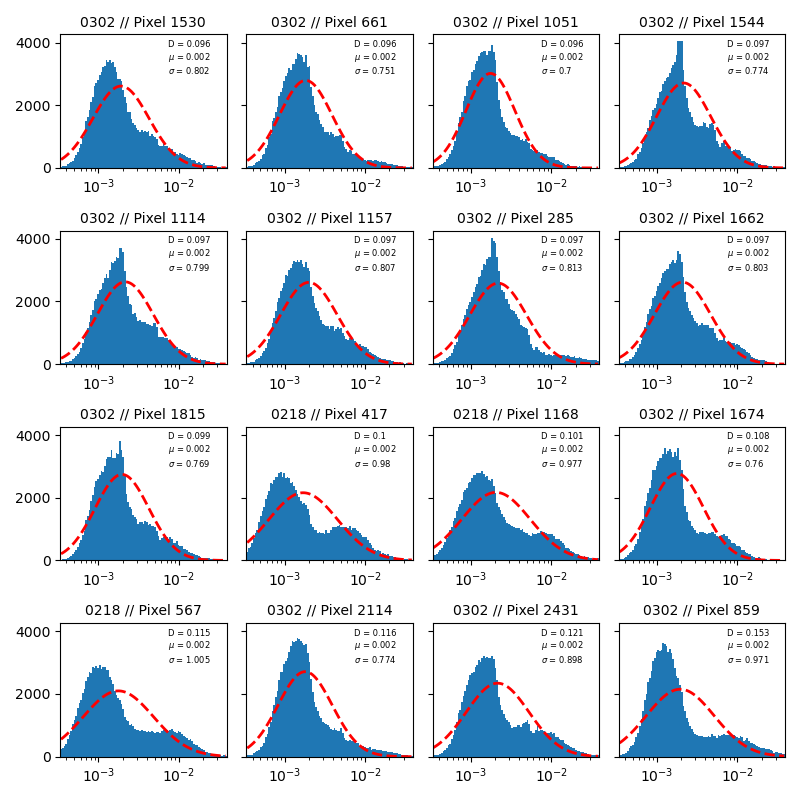

In [89]:
# Find 16 highest K-S statistics
data_ks_sort = targets.sort_values(by='ks')
ks_max = data_ks_sort.iloc[-16:].index
ks_min = data_ks_sort[:16].index
ks_med = data_ks_sort[len(data_ks_sort)//2-8:len(data_ks_sort)//2+8].index

files = [f'input_data/s1_pixels/{i[0]}/s1_{i[1]}.csv' for i in ks_max]
# files = [f'input_data/s1_pixels/0218/s1_1444.csv',
#          f'input_data/s1_pixels/0218/s1_1058.csv',
#          f'input_data/s1_pixels/0218/s1_86.csv',
#          f'input_data/s1_pixels/0218/s1_1064.csv',
#          f'input_data/s1_pixels/0218/s1_37.csv',
#          f'input_data/s1_pixels/0218/s1_108.csv',
#          f'input_data/s1_pixels/0218/s1_922.csv',
#          f'input_data/s1_pixels/0218/s1_887.csv',
#          f'input_data/s1_pixels/0218/s1_168.csv']
# files = [f'input_data/s1_pixels/0302/s1_1856.csv',
#          f'input_data/s1_pixels/0302/s1_1851.csv',
#          f'input_data/s1_pixels/0302/s1_2367.csv',
#          f'input_data/s1_pixels/0302/s1_1272.csv',
#          f'input_data/s1_pixels/0302/s1_1998.csv',
#          f'input_data/s1_pixels/0302/s1_2135.csv',
#          f'input_data/s1_pixels/0302/s1_738.csv',
#          f'input_data/s1_pixels/0302/s1_850.csv',
#          f'input_data/s1_pixels/0302/s1_2400.csv',
#          f'input_data/s1_pixels/0302/s1_1946.csv']
# files = [f'input_data/s1_pixels/0302/s1_2067.csv',
#          f'input_data/s1_pixels/0302/s1_2441.csv',
#          f'input_data/s1_pixels/0302/s1_104.csv',
#          f'input_data/s1_pixels/0302/s1_1519.csv',
#          f'input_data/s1_pixels/0302/s1_2088.csv',
#          f'input_data/s1_pixels/0302/s1_786.csv',
#          f'input_data/s1_pixels/0302/s1_1066.csv',
#          f'input_data/s1_pixels/0302/s1_1258.csv',
#          f'input_data/s1_pixels/0302/s1_1675.csv',
#          f'input_data/s1_pixels/0302/s1_2131.csv',
#          f'input_data/s1_pixels/0218/s1_1371.csv']        

nbins = 100        
p1 = 0.00033491218
p99 = 0.0389023134
bins_log = np.logspace(np.log10(p1), np.log10(p99), nbins)

plt.close('all')
fig, ax = plt.subplots(4, 4, figsize=(8, 8))
axs = ax.flatten()      
ylim_0 = 10
ylim_1 = -1
for i in range(len(files)):
    # Read data
    pixel_id = files[i].split('s1_')[-1].split('.')[0]
    date_title = re.findall('\d{3,}', files[i])[0]
    data = pd.read_csv(files[i], index_col=0)
    data[data['std_dev'] == 0] = np.nan
    data.dropna(inplace=True)
    # Calculate bins by percentile
#     p1 = data['std_dev'].quantile(0.001)
#     p99 =  data['std_dev'].quantile(0.999)
#     bins_log = np.logspace(np.log10(p1), np.log10(p99), nbins)
    
    # scale = mean (np.exp(mu)); shape = SD (sigma); force loc = 0
    shape, loc, scale = lognorm.fit(data['std_dev'], floc=0)
    # Create CDF from fitted model, take difference for smooth PDF
    estimated_cdf = lognorm.cdf(bins_log, shape, loc=loc, scale=scale)
    estimated_pdf = np.diff(estimated_cdf)
    # Anderson-Darling and K-S statistic
    ad_stat, crit_vals, sig_levels = anderson(data['std_dev'], dist='logistic')
    ks_stat, ks_pval = kstest(data['std_dev'], 'lognorm', args=(shape, loc, scale))
    results = [pixel_id, scale, shape, ks_stat, ad_stat]
#     results_list.append(results)
#     if i != 0 and not i%100:
#         print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
#               f'-- {i} files complete.')
    #Plotting
    # Find histogram bin centers for plotting
    bins_log_cntr = (bins_log[1:] + bins_log[:-1]) / 2
    counts, bin_edges, ignored = axs[i].hist(data['std_dev'], bins_log, density=False)
    # Need to scale PDF by bin heights to align on plot
    axs[i].plot(bins_log_cntr, estimated_pdf * counts.sum(), 'r--', lw=2)
    axs[i].set_xscale('log')
    axs[i].set_xlim(bin_edges.min(), bin_edges.max())
    axs[i].text(0.65, 0.7, f'D = {round(ks_stat, 3)}\n$\mu$ = {round(scale, 3)}\n$\sigma$ = {round(shape, 3)}', 
                transform=axs[i].transAxes, fontsize=6)
    axs[i].set_title(date_title + ' // Pixel '+ files[i].split('s1_')[-1].split('.')[0], fontsize=10)
    if i%4:
        axs[i].tick_params(labelleft=False)
    if axs[i].get_ylim()[0] < ylim_0:
        ylim_0 = axs[1].get_ylim()[0]
    if axs[i].get_ylim()[1] > ylim_1:
        ylim_1 = axs[i].get_ylim()[1]

for axs in ax.flatten():
    axs.set_ylim(ylim_0, ylim_1)
plt.tight_layout()
#fig.savefig('output/figures/distributions/inspect_0302_grinch.png', dpi=300)

In [93]:
len(counts)

99

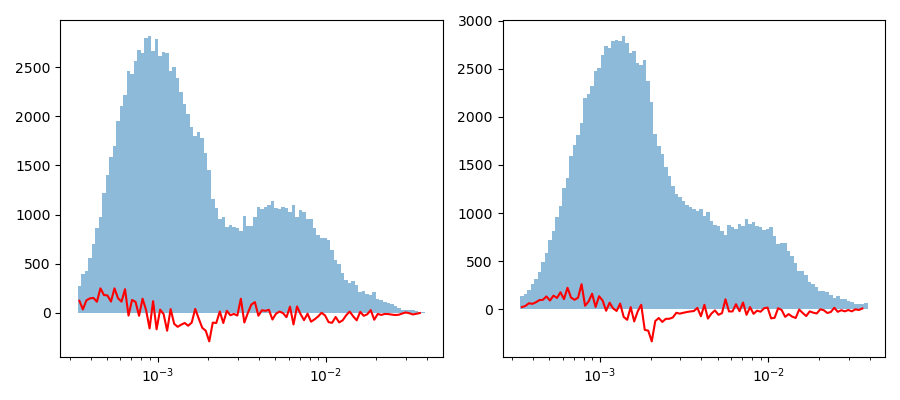

In [98]:
files = [f'input_data/s1_pixels/0218/s1_417.csv',
          'input_data/s1_pixels/0218/s1_1168.csv']
nbins = 100        
p1 = 0.00033491218
p99 = 0.0389023134
bins_log = np.logspace(np.log10(p1), np.log10(p99), nbins)

plt.close('all')
# fig, ax = plt.subplots(4, 4, figsize=(8, 8))
# axs = ax.flatten()      
# ylim_0 = 10
# ylim_1 = -1

fig, ax = plt.subplots(1, 2, figsize=(9,4))
axs = ax.flatten()
for i in range(len(files)):
    # Read data
    pixel_id = files[i].split('s1_')[-1].split('.')[0]
    date_title = re.findall('\d{3,}', files[i])[0]
    data = pd.read_csv(files[i], index_col=0)
    data[data['std_dev'] == 0] = np.nan
    data.dropna(inplace=True)
    
    counts, bin_edges, ignored = axs[i].hist(data['std_dev'], bins_log, density=False, alpha=0.5)
    bins_center = (bins_log[1:] + bins_log[:-1]) / 2
    counts_prime = pd.DataFrame(np.diff(counts))
    counts_prime
    axs[i].plot(bins_center[:-1], counts_prime, 'r')
    axs[i].set_xscale('log')

plt.tight_layout()
    
    

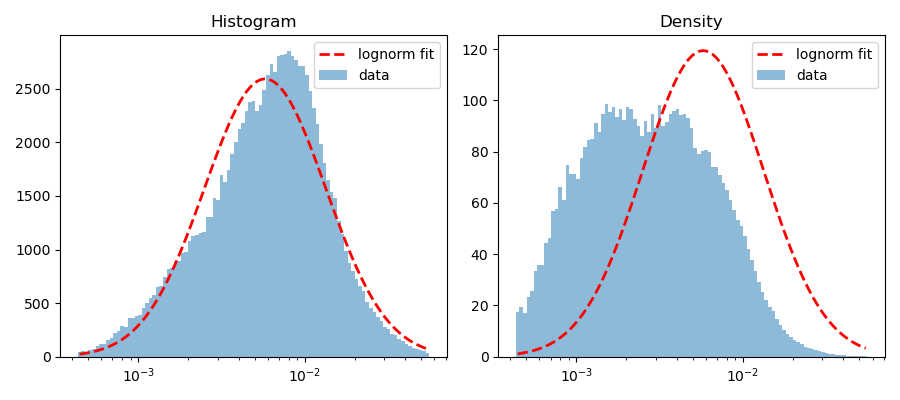

In [88]:
# stack exchange example

files = [f'input_data/s1_pixels/0218/s1_1347.csv']
i = 0
data = pd.read_csv(files[i], index_col=0)
data[data['std_dev'] == 0] = np.nan
data.dropna(inplace=True)

dataa = data['std_dev']
p1 = np.quantile(dataa, 0.001)
p99 = np.quantile(dataa, 0.999)
bins = np.logspace(np.log10(p1), np.log10(p99), 100)
bins_center = (bins[1:] + bins[:-1]) / 2

shape, loc, scale = lognorm.fit(dataa, floc=0)
estimated_cdf = lognorm.cdf(bins, shape, loc=loc, scale=scale)
estimated_pdf = np.diff(estimated_cdf)

fig, ax = plt.subplots(1, 2, figsize=(9,4))
counts, bin_edges, ignored = ax[0].hist(dataa, bins, density=False, alpha=0.5, label='data')
ax[0].plot(bins_center, estimated_pdf * counts.sum(), 'r--', lw=2, label='lognorm fit')
ax[0].set_xscale('log')
ax[0].legend()
ax[0].set_title('Histogram')

counts, bin_edges, ignored = ax[1].hist(dataa, bins, density=True, alpha=0.5, label='data')
ax[1].plot(bins_center, estimated_pdf * counts.sum(), 'r--', lw=2, label='lognorm fit')
ax[1].set_xscale('log')
ax[1].set_title('Density')
ax[1].legend()
plt.tight_layout()



In [113]:
counts_prime = pd.DataFrame(np.diff(counts), columns=['diff'])
n_streaks = 0
for i in range(len(counts_prime)):
    if np.sign(counts_prime.loc[i+1, 'diff']) != np.sign(counts_prime.loc[i, 'diff']):
        n_streaks += 1

streak_list = [1]
streak = 1
for i in range(len(counts_prime)-1):
    if np.sign(counts_prime.loc[i+1, 'diff']) == np.sign(counts_prime.loc[i, 'diff']):
        streak += 1
        streak_list.append(streak)
    else:
        streak = 1
        streak_list.append(streak)
counts_prime['streak'] = streak_list


for i in range(n_streaks):
    cp_sorted = counts_prime.sort_values(by='streak', ascending=False)
    for 
for i in cp_sorted.index[15:20]:
    streak = cp_sorted.loc[i, 'streak']
    span = streak - 2
    print(i, streak, span)
    print(np.arange(i-span, i))


11 12 10
[ 1  2  3  4  5  6  7  8  9 10]
46 12 10
[36 37 38 39 40 41 42 43 44 45]
10 11 9
[1 2 3 4 5 6 7 8 9]
45 11 9
[36 37 38 39 40 41 42 43 44]
84 11 9
[75 76 77 78 79 80 81 82 83]


In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.stats import norm, lognorm, anderson, kstest
from sklearn import metrics
from rf_functions import data_setup, run_rf_reg, run_rf_cla
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None


s1_fp = 'input_data/s1_zonal_data.csv'
stats_fp = 'output/stats/scale_shape_both_dates.csv'
moran_fp = 'input_data/moran_max.csv'
output_dir_predict = 'output/rf_predictions/single_date/'
output_dir_metrics = 'output/rf_metrics/single_date/'
out_file_prefix = 'func_test_dB'

targets, predictors = data_setup(s1_fp, stats_fp, moran_fp, s1_units='dB', date=None)
cols_0218 = [c for c in targets.columns if '0219' in c]
cols_0302 = [c for c in targets.columns if '0304' in c]
cols_misc = [c for c in targets.columns if c not in cols_0218 and c not in cols_0302]
cols_misc.remove('Point_ID')
cols_misc.remove('moran_p')
cols_0218 += cols_misc
cols_0302 += cols_misc

cols_0218 = [c for c in cols_0218 if '10m' in c]
cols_0302 = [c for c in cols_0302 if '10m' in c]

targets_0218 = targets[cols_0218].dropna()
targets_0302 = targets[cols_0302].dropna()

# run_rf_reg(targets_0218, predictors.loc[targets_0218.index], n_runs=100, 
#        rf_type='single_target', output_dir_predict=output_dir_predict,
#        output_dir_metrics=output_dir_metrics, out_file_prefix=out_file_prefix)
# run_rf_reg(targets_0302, predictors.loc[targets_0302.index], n_runs=100, 
#        rf_type='single_target', output_dir_predict=output_dir_predict,
#        output_dir_metrics=output_dir_metrics, out_file_prefix=out_file_prefix)

output_dir_predict = 'output/rf_predictions/multi_date/'
output_dir_metrics = 'output/rf_metrics/multi_date/'
out_file_prefix = 'func_test_dB'

def remove_date(col):
    if '0219' in col:
        date_start = col.index('0219')
    elif '0304' in col:
        date_start = col.index('0304')
    else:
        return col
    
    new_col = col[:date_start] + col[date_start+5:]
    if '_1_' in new_col:
        ind = new_col.index('_1_')
        new_col = new_col[:ind] + new_col[ind+2:]
    return new_col

cols_0218_new = [remove_date(c) for c in cols_0218]
cols_0302_new = [remove_date(c) for c in cols_0302]

targets_0218.columns = cols_0218_new
targets_0302.columns = cols_0302_new

targets_all = pd.concat([targets_0218, targets_0302])

# run_rf_reg(targets_all, predictors, n_runs=100, rf_type='single_target', 
#        output_dir_predict=output_dir_predict, output_dir_metrics=output_dir_metrics, 
#        out_file_prefix=out_file_prefix)

In [5]:
targets_all
output_dir_predict = 'output/rf_classification/class_results/single_date/'
output_dir_cm = 'output/figures/confusion/'
out_file_prefix = 'func_test_classification'

rf_params = {
    'n_estimators': 2000,
    'max_features': 2/3,
    'max_depth': 7,
    'random_state': 5033
}

n_classes = [0, 25, 75, 100]

run_rf_cla(targets_all[['zonal_10m_max','zonal_10m_min']], predictors, n_runs=2, 
    rf_params=rf_params, n_classes=5, 
    output_dir_predict=output_dir_predict, out_file_prefix=out_file_prefix,
    output_dir_cm=output_dir_cm)

2022-07-18 12:37:35 -- Starting RF classification (2 targets total).
2022-07-18 12:37:35 -- Starting target zonal_10m_max (1/2 targets)


  0%|          | 0/2 [00:00<?, ?it/s]

2022-07-18 12:38:10 -- Starting target zonal_10m_min (2/2 targets)


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
target_raw = targets_all['zonal_10m_min']
n_classes = 5
p_bounds = np.linspace(0, 100, n_classes+1)
percentiles = [np.percentile(target_raw, p) for p in p_bounds]
class_labels = np.arange(1, len(p_bounds))
y = pd.cut(target_raw, bins=percentiles, labels=class_labels)
y

date  S1_pixel_ID
0218  1              3
      2              5
      3              4
      4              4
      5              4
                    ..
0302  2473           2
      2474           2
      2476           2
      2477           1
      2478           1
Name: zonal_10m_min, Length: 3691, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]

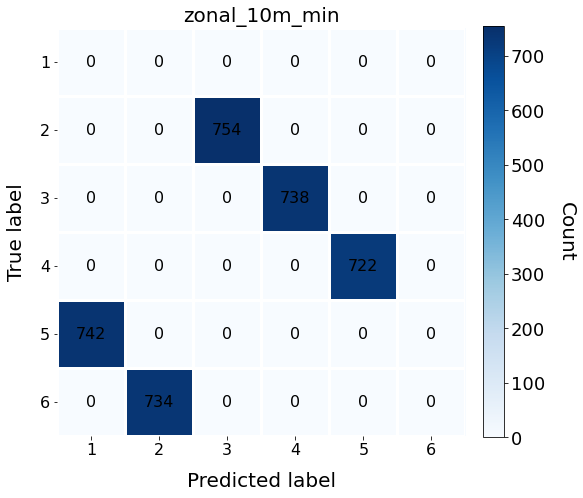

In [10]:
cm = metrics.confusion_matrix(y.dropna(), (y.dropna().astype(int)+np.random.randint(2))%5)
fig, ax = plt.subplots(figsize=(8,8))
cmap='Blues'
vmin=0
vmax=cm.max()
cbar_label='Count'
xlabel=True
ylabel=True
fig_title='zonal_10m_min'
output_dir_cm=None


im = ax.imshow(cm, cmap=cmap, vmin=vmin, vmax=vmax)
ax.set_xticks(np.arange(cm.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(cm.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
ax.tick_params(axis='both', which='minor', bottom=False, left=False)
ax.set_xticks(ax.get_xticks()[1:-1])
ax.set_yticks(ax.get_yticks()[1:-1])
ax.set_xticklabels(np.arange(1,len(cm)+1), fontsize=16)
ax.set_yticklabels(np.arange(1,len(cm)+1), fontsize=16)
cbar_ratio = cm.shape[0]/cm.shape[1]
cbar = plt.colorbar(im, ax=ax, fraction=0.046*cbar_ratio, pad=0.04)
cbar.ax.tick_params(labelsize=18)
if cbar_label: 
    cbar.ax.set_ylabel(cbar_label, rotation=-90, 
                        va='bottom', fontsize=20, labelpad=12)

for i in range(len(cm)):
    for k in range(len(cm)): # cm guaranteed to be square
        text = ax.text(k, i, cm[i, k], fontsize=16,
                    ha='center', va='center', color='k')

ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

if xlabel: 
    ax.set_xlabel('Predicted label', fontsize=20, labelpad=14)
if ylabel: 
    ax.set_ylabel('True label', fontsize=20, labelpad=14)
if fig_title:
    ax.set_title(fig_title, fontsize=20)

ax.get_xticks(minor=True)


In [25]:
y.loc[pd.isnull(y)]

date  S1_pixel_ID
0302  1395           NaN
Name: zonal_10m_min, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [3]:
type([]) == list

True